In [35]:
%matplotlib inline


In [2]:
import matplotlib as plt
plt.use("Agg")
import pandas as pd
import os
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
import time
from sentence_transformers import SentenceTransformer
import seaborn as sns

/home/karolina/LDA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reading the data & filtering the tenancy judgments

In [ ]:
encodings = ['utf-8']

for enc in encodings:
    try:
        df = pd.read_csv("data.csv", encoding=enc)
        break
    except UnicodeDecodeError:
        continue

In [ ]:
def first_instance(text):
    if('pelacj' in text): # 'appeal' - pol. 'apelacja', can start with a capital, can end with different letters due to declination
        return 0
    else:
        return 1

df['firstInstance'] = df['textContent'].map(lambda x: first_instance(x)) # indicates if this is the first instance, if not it should be an appeal


In [ ]:
index = []
for i in range(0,len(df['textContent'])):
    if(df['firstInstance'][i] == 1): # first instance decisions only
        if any(element in df['textContent'][i] for element in ['czynsz','czynszem', 'czynszu']): 
            index.append(i)

In [ ]:
df= df.iloc[index].reset_index(drop=True)

In [4]:
print(df.shape)
df.head()

(1104, 9)


,Unnamed: 0,courtType,caseNumber,judgmentType,textContent,publicationDate,judgmentDate,judgesName,firstInstance
0,0,COMMON,II Cz 82/14,DECISION,"Sygnatura akt II Cz 82/14\n Jelenia Góra, d...",2014-02-19,2014-01-30,Jadwiga Jakubowska,1
1,1,COMMON,VIII GC 897/13,SENTENCE,Sygn. akt VIII GC 897/13 upr\n \n \n ...,2015-05-26,2014-01-30,Ewa Kurowska,1
2,2,COMMON,I C 1732/13,SENTENCE,I C 1732/13\n \n WYROK\n W IMIENI...,2015-06-09,2014-01-30,Katarzyna Gawecka,1
3,3,COMMON,I C 481/13,REASONS,Sygn. akt I C 481/13\n \n UZASADNIENIE...,2014-02-21,2014-01-30,NaN,1
4,4,COMMON,I C 1585/13,SENTENCE,Sygnatura akt I Cupr 1585/13\n \n \n ...,2014-06-03,2014-01-30,Paweł Kwiatkowski,1


Most of the texts have less than 50000 characters. There were few files with >100k characters but we decided not to include them in our analysis.

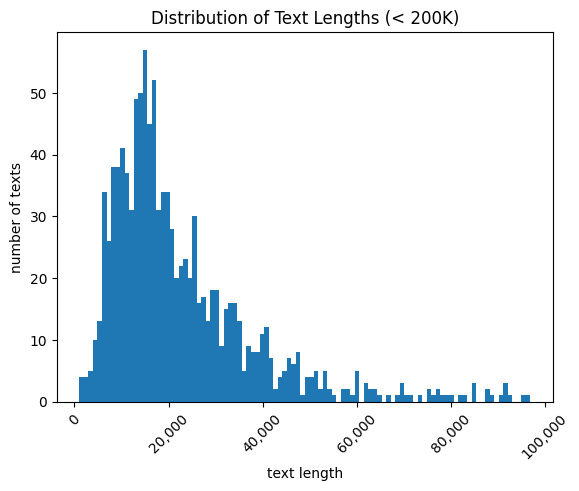

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
texts_lengths = df['textContent'].fillna("").astype(str).map(len)
plt.hist(texts_lengths[texts_lengths < 200_000], bins=100, density=False)
plt.xlabel('text length')
plt.ylabel('number of texts')
plt.title('Distribution of Text Lengths (< 200K)')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xticks(rotation=45)
plt.show()

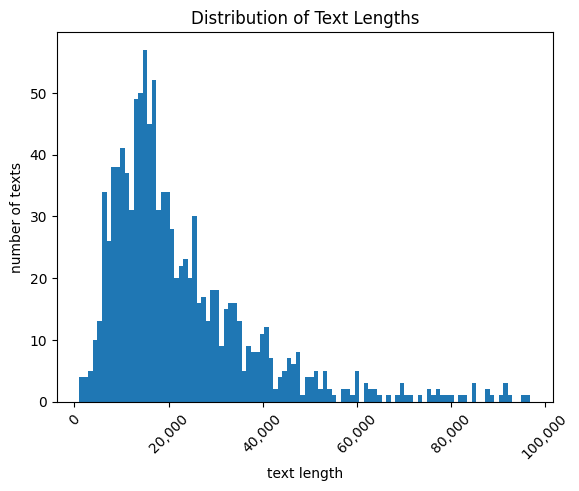

In [38]:
max(texts_lengths)
df = df[df['textContent'].str.len() < 100_000]
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
texts_lengths = df['textContent'].fillna("").astype(str).map(len)
plt.hist(texts_lengths, bins=100, density=False)
plt.xlabel('text length')
plt.ylabel('number of texts')
plt.title('Distribution of Text Lengths')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xticks(rotation=45)
plt.show()

In [7]:
#the shortest text have only 1056 characters
min(texts_lengths)

1056

In [8]:
#after excluding very long texts (>100k characters), we are left with 1092 observations
df.shape[0]

1092

In [9]:
data = df[['judgmentDate', 'publicationDate','textContent']]

In [10]:
data['textContent'][1]

'Sygn. akt VIII GC 897/13 upr\n    \n    \n      WYROK\n      W IMIENIU RZECZYPOSPOLITEJ POLSKIEJ\n      (zaoczny w stosunku do Zakład (...) spółkę z ograniczoną odpowiedzialnością\n\n      spółki z ograniczoną odpowiedzialnością w O.)\n      \n         Dnia 30 stycznia 2014 r.\n      \n      Sąd Rejonowy w Białymstoku VIII Wydział Gospodarczy\n      w składzie:\n      \n      Przewodniczący :  SSR Ewa Kurowska\n      Protokolant:  Małgorzata Białous\n      \n      po rozpoznaniu w dniu 22 stycznia 2014 r. w Białymstoku\n      na rozprawie\n      sprawy z powództwa B. Spółdzielni Mieszkaniowej w B.\n\n      przeciwko Zakład (...) spółkę z ograniczoną odpowiedzialnościąspółce komandytowej w O.oraz\n      \nZakład (...) spółkę z ograniczoną odpowiedzialnościąw W.\n\n      o zapłatę\n      \n      \n        \n        I.\xa0\n        Zasądza od pozwanego Zakład (...) spółkę z ograniczoną odpowiedzialnościąspółki komandytowej w O.na rzecz powoda B.Spółdzielnia Mieszkaniowej w B.kwotę 12 243

In [ ]:
# missing values - we have 18 observations without publication date
pd.isnull(data).sum()

judgmentDate        0
publicationDate    18
textContent         0
dtype: int64

In [12]:
# duplicates - there are no duplicates
data.duplicated().any()

np.False_

In [13]:
data['textContent'] = data['textContent'].astype('string')
data['judgmentDate'] = pd.to_datetime(data['judgmentDate'])
data['publicationDate'] = pd.to_datetime(data['publicationDate'])

Topic Modelling

In [14]:
#tokenization
import spacy
nlp = spacy.load("pl_core_news_sm")

def spacy_tokenize(text):
    doc = nlp(text)
    return [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop
        and not token.is_punct
        and not token.is_space
        and token.is_alpha          # Only alphabetic tokens (no digits, symbols)
        and len(token.text) > 1     ]

data['tokens'] = data['textContent'].map(spacy_tokenize)

In [15]:
#tokens
print(data['tokens'])

0       [sygnatura, akta, ii, cz, jeleni, góra, dzień,...
1       [sygn, akt, gc, upr, wyrok, imieniu, rzeczypos...
2       [wyrok, imieniu, rzeczypospolitej, polskiej, d...
3       [sygn, akt, uzasadnienie, pozwem, dzień, wrzes...
4       [sygnatura, akta, cupr, wyrok, imieniu, rzeczy...
                              ...                        
1099    [sygnatura, akta, cupr, wyrok, imieniu, rzeczy...
1100    [sygn, akt, xvi, gc, wyrok, imieniu, rzeczypos...
1101    [sygn, akt, iii, rc, wyrok, imieniu, rzeczypos...
1102    [sygn, akt, rc, wyrok, imieniu, rzeczypospolit...
1103    [sygn, akt, xvii, amc, uzasadnienie, pozwem, d...
Name: tokens, Length: 1092, dtype: object


In [16]:
#we are importing stop words that we will delete from the tokens
stop_words= nlp.Defaults.stop_words
print(stop_words)

{'znow', 'cały', 'cos', 'powinna', 'juz', 'xiv', 'niemu', 'vi', 'dwoje', 'znowu', 'cie', 'ci', 'twym', 'nami', 'powinno', 'został', 'takie', 'po', 'inna', 'go', 'więcej', 'naszych', 'rowniez', 'nic', 'oni', 'przecież', 'dosc', 'tam', 'tobą', 'mną', 'pana', 'inny', 'zadnych', 'prawie', 'tobie', 'moje', 'totez', 'być', 'tej', 'ktos', 'mozliwe', 'natomiast', 'bede', 'żeby', 'też', 'aby', 'beda', 'dokad', 'jezeli', 'kto', 'cala', 'ją', 'każdy', 'którego', 'iz', 'niej', 'mam', 'ty', 'których', 'gdyż', 'tu', 'cokolwiek', 'jestem', 'jego', 'daleko', 'xi', 'niż', 'skad', 'one', 'wszystkim', 'ktorzy', 'jakichś', 'z', 'przeciez', 'lub', 'jakaś', 'niego', 'taka', 'dokąd', 'nie', 'zaden', 'totobą', 'bowiem', 'by', 'gdy', 'temu', 'będzie', 'aj', 'ktore', 'zeby', 'również', 'jakoś', 'mają', 'wam', 'nich', 'będę', 'pan', 'iv', 'twój', 'we', 'ona', 'także', 'vii', 'są', 'jakas', 'co', 'skąd', 'to', 'ależ', 'niz', 'więc', 'coraz', 'znów', 'o', 'przede', 'nigdy', 'kazdy', 'według', 'bardzo', 'moja', 'ow

In [17]:
#deleting stop words
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

data['tokens'] = data['tokens'].map(remove_stopwords)
data['text cleaned'] = data['tokens'].map(lambda tokens: ' '.join(tokens))

In [18]:
#cleaned text
data['text cleaned']

0       sygnatura akta ii cz jeleni góra dzień styczeń...
1       sygn akt gc upr wyrok imieniu rzeczypospolitej...
2       wyrok imieniu rzeczypospolitej polskiej dzień ...
3       sygn akt uzasadnienie pozwem dzień wrzesień wn...
4       sygnatura akta cupr wyrok imieniu rzeczypospol...
                              ...                        
1099    sygnatura akta cupr wyrok imieniu rzeczypospol...
1100    sygn akt xvi gc wyrok imieniu rzeczypospolitej...
1101    sygn akt iii rc wyrok imieniu rzeczypospolitej...
1102    sygn akt rc wyrok imieniu rzeczypospolitej pol...
1103    sygn akt xvii amc uzasadnienie pozwem dzień gr...
Name: text cleaned, Length: 1092, dtype: object

In [19]:
#we are counting the tokens 
from collections import Counter  # Correct import

all_tokens = [token for tokens in data['tokens'] for token in tokens]

token_counts = Counter(all_tokens)

most_common=token_counts.most_common(50)
print(most_common)


[('dzień', 40938), ('złoty', 35262), ('pozwany', 24393), ('sąd', 22052), ('kwota', 20784), ('umowa', 19246), ('powód', 18518), ('artykuł', 17118), ('strona', 15667), ('koszt', 15217), ('lokal', 13376), ('sprawa', 13050), ('numer', 10411), ('rzecz', 9428), ('powódka', 9363), ('zostać', 8596), ('podstawa', 8408), ('nieruchomość', 8301), ('najem', 8264), ('dowód', 8106), ('wysokość', 8073), ('tytuł', 7720), ('pozwać', 7388), ('należeć', 7267), ('zapłata', 7132), ('prawo', 7119), ('wskazać', 6812), ('postępowanie', 6635), ('zakres', 6574), ('okres', 6498), ('osoba', 6069), ('opłata', 5986), ('prawny', 5941), ('powództwo', 5878), ('czynsz', 5849), ('ustalić', 5831), ('wyrok', 5801), ('miesięcznie', 5779), ('zeznanie', 5658), ('stan', 5643), ('zgodnie', 5455), ('mieć', 5449), ('akt', 5187), ('praca', 5091), ('spółka', 5080), ('pismo', 4961), ('wynikać', 4958), ('przepis', 4945), ('okoliczność', 4923), ('pojazd', 4834)]


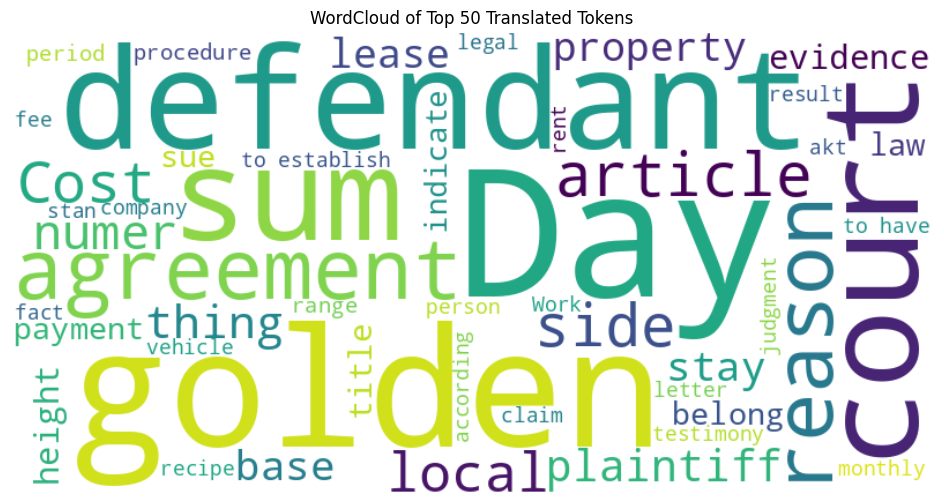

In [39]:
#word cloud of 50 most common transaled tokens
#day, court, defendant, zloty (currency), etc
from deep_translator import GoogleTranslator
from wordcloud import WordCloud

translations = {}
for token, _ in most_common:
    try:
        translated = GoogleTranslator(source='auto', target='en').translate(token)
        translations[token] = translated
    except Exception as e:
        print(f"Error translating '{token}': {e}")
        translations[token] = token  # fallback

# Build new frequency dictionary with translated tokens
translated_counts = {translations[token]: count for token, count in most_common}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(translated_counts)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Top 50 Translated Tokens")
plt.show()

In [21]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(
    ngram_range=(1,1),  # Use unigrams (individual words) only
    max_df=0.95,         # Exclude terms that appear in more than 90% of documents
    min_df=0.05,        # Include terms that appear in at least 5% of the documents
    tokenizer=spacy_tokenize,  # Use the word_tokenize function to tokenize text
    stop_words=list(stop_words)  # Exclude predefined stopwords (e.g., "the", "is", etc.)
)

In [22]:
tf_matrix = tf_vectorizer.fit_transform(data['text cleaned'])
filtered_feature_names = tf_vectorizer.get_feature_names_out()
print(filtered_feature_names[:20]) 

['aca' 'adekwatny' 'administracja' 'administracyjny' 'adres' 'adwokacki'
 'adwokat' 'agnieszka' 'akceptować' 'akcyjny' 'akt' 'akta' 'aktać'
 'aktualnie' 'aktualny' 'albowiem' 'aliment' 'alimentacja' 'alimentacyjny'
 'alimentacyjnych']


In [23]:
data['text cleaned'][1]

'sygn akt gc upr wyrok imieniu rzeczypospolitej polskiej zaoczny stosunek zakład spółka ograniczony odpowiedzialność spółka ograniczyć odpowiedzialność dzień styczeń sąd rejonowy białystok wydział gospodarczy skład przewodniczący ssr ewa kurowska protokolant małgorzata białous rozpoznać dzień styczeń białystok rozprawa sprawa powództwo spółdzielnia mieszkaniowy przeciwko zakład spółka ograniczić odpowiedzialnościąspółce komandytowy zakład spółka ograniczyć odpowiedzialnościąw zapłata zasądzać pozwany zakład spółka ograniczyć odpowiedzialnościąspółka komandytowy rzecz powód spółdzielnia mieszkaniowy złoty dwanaść tysiąc dwieście czterdzieści trzy złoty siedemdziesiąt pięć grosz ustawowy odsetka dzień dzień zapłata zasądzać pozwany zakład spółka ograniczyć odpowiedzialność rzecz powód spółdzielnia mieszkaniowy kwota złoty dwanaść tysiąc dwieście czterdzieści trzy złoty siedemdziesiąt pięć grosz ustawowy odsetka dzień dzień zapłat spełnieć świadczyć zasądzonego niniejszy wyrokiem pozwany 

In [24]:
data.to_csv("data_prepared.csv")


In [25]:
#cross validation with 5 folds grid search to find the best hyperparameters for LDA
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


X = tf_vectorizer.fit_transform(data['text cleaned'])

lda_model = LatentDirichletAllocation(random_state=0)

param_grid = {
    'n_components': range(5,20),  # Test different numbers of topics
    'learning_method': ['online', 'batch'],  # Try both methods
    'learning_offset': [10.0, 50.0, 100.0],  # Experiment with learning offset
    'max_iter': [5, 10, 50]  # Vary max iterations
}


grid_search = GridSearchCV(lda_model, param_grid, cv=3, n_jobs=1)


grid_search.fit(X)


print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'learning_method': 'batch', 'learning_offset': 10.0, 'max_iter': 50, 'n_components': 15}
Best Score:  -3492562.1456495146


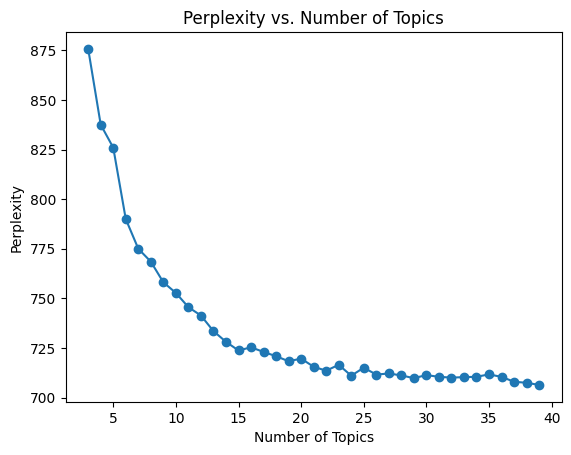

In [40]:
#perplexity
#the best perplexity is for ~15 topics
perplexity_scores = []
n_topics_range = range(3, 40)  

for n in n_topics_range:
    model = LatentDirichletAllocation(n_components=n, random_state=0)
    model.fit(X)
    perplexity_scores.append(model.perplexity(X))

import matplotlib.pyplot as plt

plt.plot(n_topics_range, perplexity_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Number of Topics')
plt.show()

In [27]:
best_lda_model = grid_search.best_estimator_

In [28]:
#printing top 10 words for each topic
lda_model.fit(X)
for i,topic in enumerate(best_lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['gmina', 'prawny', 'osoba', 'ulica', 'prawo', 'mieszkalny', 'umowa', 'najem', 'pozwać', 'lokal']


Top 10 words for topic #1:
['umowy', 'zostać', 'vat', 'zawrzeć', 'spółka', 'powód', 'strona', 'numer', 'pozwać', 'umowa']


Top 10 words for topic #2:
['odszkodowanie', 'tytuł', 'związek', 'osoba', 'śmierć', 'powod', 'zeznanie', 'szkoda', 'pozwać', 'powód']


Top 10 words for topic #3:
['prawo', 'wspólnota', 'wspólny', 'nieruchomość', 'zarząd', 'uchwała', 'mieszkaniowy', 'lokal', 'członek', 'spółdzielnia']


Top 10 words for topic #4:
['posiadać', 'budynek', 'właściciel', 'pozwać', 'własność', 'grunt', 'korzystać', 'działka', 'numer', 'nieruchomość']


Top 10 words for topic #5:
['wysokość', 'potrzeba', 'małoletni', 'matka', 'powód', 'aliment', 'dziecko', 'utrzymać', 'pozwać', 'miesięcznie']


Top 10 words for topic #6:
['ustawa', 'ustęp', 'wykonywać', 'wynagrodzenie', 'wnioskodawca', 'społeczny', 'świadczenie', 'ubezpieczenie', 'pracownik', 'praca']


Top 10 w

In [29]:
#best 5 words
for i,topic in enumerate(best_lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-5:]])
    print('\n')

Top 10 words for topic #0:
['mieszkalny', 'umowa', 'najem', 'pozwać', 'lokal']


Top 10 words for topic #1:
['powód', 'strona', 'numer', 'pozwać', 'umowa']


Top 10 words for topic #2:
['powod', 'zeznanie', 'szkoda', 'pozwać', 'powód']


Top 10 words for topic #3:
['uchwała', 'mieszkaniowy', 'lokal', 'członek', 'spółdzielnia']


Top 10 words for topic #4:
['grunt', 'korzystać', 'działka', 'numer', 'nieruchomość']


Top 10 words for topic #5:
['aliment', 'dziecko', 'utrzymać', 'pozwać', 'miesięcznie']


Top 10 words for topic #6:
['społeczny', 'świadczenie', 'ubezpieczenie', 'pracownik', 'praca']


Top 10 words for topic #7:
['wyrok', 'przepis', 'prawo', 'prawny', 'postępowanie']


Top 10 words for topic #8:
['udział', 'postępowanie', 'wspólny', 'wartość', 'majątek']


Top 10 words for topic #9:
['opłata', 'pozwać', 'strona', 'najem', 'lokal']


Top 10 words for topic #10:
['poszkodować', 'pozwać', 'szkoda', 'najem', 'pojazd']


Top 10 words for topic #11:
['spółka', 'osoba', 'mieć', 'ś

In [30]:
#translated words
from deep_translator import GoogleTranslator

for i, topic in enumerate(best_lda_model.components_):
    print(f'Top 10 words for topic #{i}:')

    top_words = [tf_vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]

    translated = [GoogleTranslator(source='auto', target='en').translate(word) for word in top_words]
    print("Translated:", translated)
    print('\n')


Top 10 words for topic #0:
Translated: ['commune', 'legal', 'person', 'street', 'law', 'residential', 'agreement', 'lease', 'sue', 'local']


Top 10 words for topic #1:
Translated: ['contracts', 'stay', 'vat', 'conclude', 'company', 'reason', 'side', 'numer', 'sue', 'agreement']


Top 10 words for topic #2:
Translated: ['compensation', 'title', 'relationship', 'person', 'death', 'Powod', 'testimony', 'Pity', 'sue', 'reason']


Top 10 words for topic #3:
Translated: ['law', 'community', 'common', 'property', 'management', 'resolution', 'housing', 'local', 'member', 'cooperative']


Top 10 words for topic #4:
Translated: ['to have', 'building', 'owner', 'sue', 'property', 'grunt', 'to use', 'plot', 'numer', 'property']


Top 10 words for topic #5:
Translated: ['height', 'need', 'minor', 'travel', 'reason', 'aliment', 'kid', 'maintain', 'sue', 'monthly']


Top 10 words for topic #6:
Translated: ['act', 'paragraph', 'perform', 'remuneration', 'Applicant', 'social', 'benefit', 'insurance', 

In [31]:
topic_distribution = best_lda_model.transform(X)

In [32]:
data['predicted_topic'] = topic_distribution.argmax(axis=1)

#assigning topic to each document
print("Updated dataset with predicted topics:")
print(data.head())

Updated dataset with predicted topics:
  judgmentDate publicationDate  \
0   2014-01-30      2014-02-19   
1   2014-01-30      2015-05-26   
2   2014-01-30      2015-06-09   
3   2014-01-30      2014-02-21   
4   2014-01-30      2014-06-03   

                                         textContent  \
0  Sygnatura akt II Cz 82/14
    Jelenia Góra, dn...   
1  Sygn. akt VIII GC 897/13 upr
    
    
      W...   
2  I C 1732/13
    
      WYROK
      W IMIENIU R...   
3  Sygn. akt I C 481/13
    
      UZASADNIENIE
 ...   
4  Sygnatura akt I Cupr 1585/13
    
    
      W...   

                                              tokens  \
0  [sygnatura, akta, ii, cz, jeleni, góra, dzień,...   
1  [sygn, akt, gc, upr, wyrok, imieniu, rzeczypos...   
2  [wyrok, imieniu, rzeczypospolitej, polskiej, d...   
3  [sygn, akt, uzasadnienie, pozwem, dzień, wrzes...   
4  [sygnatura, akta, cupr, wyrok, imieniu, rzeczy...   

                                        text cleaned  predicted_topic  
0  sygnatu

Topic Distribution

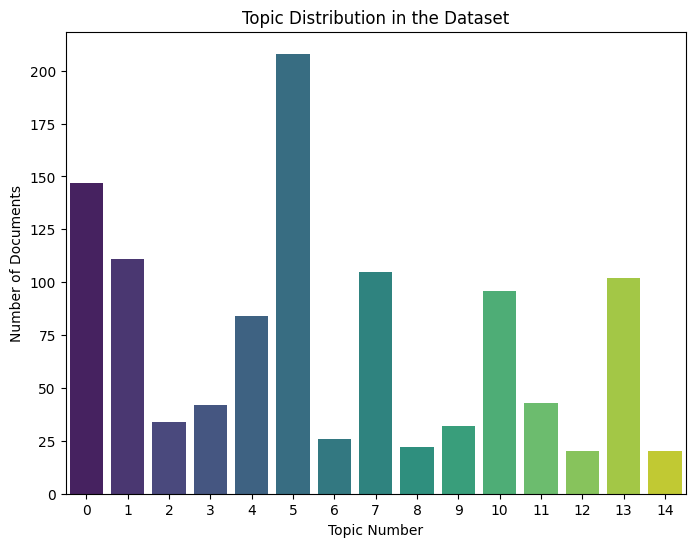

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns


topic_counts = data['predicted_topic'].value_counts().sort_index()


plt.figure(figsize=(8, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')


plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution in the Dataset')
plt.xticks(rotation=0)


plt.show()

In [34]:
data.to_csv("topics.csv")

### Conclusion

In this project, we applied a Latent District Allocation (LDA) model to legal judgements related to tenancy. Our objective was to identify the dominant topics across the documents to gain insights into the nature and scope of tenancy-related legal disputes.

The model identified 15 distinct topics, each characterized by a set of keywords. These topics represent the issues typically encountered in tenancy-related litigation, such as:

legal entities and local governance ("commune", "legal", "residential", "local")

contractual disputes ("agreement", "lease", "contracts", "company")

property and ownership ("building", "owner", "property")

compensation and damages ("compensation", "injure")

housing and cooperative management ("common", "cooperative", "housing", "management")

employment-related claims ("remuneration", "social", "insurance", "employee")

financial claims and payments ("receivable", "fee", "claim", "of payment")

Overall, the LDA model proved to perform well in order to structure a large set of legal documents. It helped us find different topics that appear in the cases which can be used for further analysis, such as predicting outcomes of legal cases.

